# Validation case for the loss model

This validation case is based on a [FEMM websites' page](https://www.femm.info/wiki/SPMLoss)

## Definition of the machine

The machine has been defined in the pyleecan GUI. Then, it must be imported.

In [1]:

import sys
from os.path import join
import pyleecan
print(f'PYLEECAN version : {pyleecan.__version__}')
from pyleecan.Functions.load import load
from pyleecan.definitions import DATA_DIR


machine = load(join(DATA_DIR, "Machine", "SPMSM_18s16p_loss.json"))

PYLEECAN version : 1.3.8


## Definition of the simulation

A simulation is defined by simply creating an instance of the Simu1 object, with a name and the machine that was defined previously.

In [2]:
from pyleecan.Classes.Simu1 import Simu1

simu = Simu1(name="Validation_Loss_SPMSM", machine=machine)

In this simulation, we will need to run the magnetic module. Thus, it has to be defined, but beforehand, we need to create an InputCurrent object to set the excitation current for the magnetic module.

In [3]:
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Classes.OPdq import OPdq
import numpy as np

simu.input = InputCurrent(
    Nt_tot=4 * 20 * 16,
    Na_tot=1000 * 2,
    OP=OPdq(N0=4000, Id_ref=0, Iq_ref=np.sqrt(2)),
    is_periodicity_t=True,
    is_periodicity_a=True,
)

simu.mag = MagFEMM(
    is_periodicity_a=True,
    is_periodicity_t=True,
    nb_worker=4,
    is_get_meshsolution=True,
    FEMM_dict_enforced={
        "simu": {"minangle": 30},
        "mesh": {
            "meshsize_airgap": 0.00014,
            "elementsize_airgap": 0.00014,
            "smart_mesh": 1,
        }
    }
)

Then, we need to create a loss object to compute the loss. This loss object needs to be given the loss coeficients, obtained by curve fitting from material data. Here, the coefficients are taken from the FEMM website.

In [4]:
from pyleecan.Classes.LossFEA import LossFEA

Ch = 143  # hysteresis loss coefficient [W/(m^3*T^2*Hz)]
Ce = 0.530  # eddy current loss coefficients [W/(m^3*T^2*Hz^2)]
Cprox = 4.1018  # sigma_w * cond.Hwire * cond.Wwire

simu.loss = LossFEA(Ce=Ce, Cp=Cprox, Ch=Ch, is_get_meshsolution=True, Tsta=120)


## Simulation

Now that the simulation is properly set up, it can simply be run with the run method. The output will be store as the out variable.

In [5]:
  out = simu.run()

[11:52:59] Starting running simulation Validation_Loss_SPMSM (machine=SPMSM_18s16p_loss_mod)
[11:52:59] Starting Magnetic module
[11:53:02] Solving time steps: 0%
[11:53:02] Solving time steps: 0%
[11:53:02] Solving time steps: 0%
[11:53:02] Solving time steps: 0%
[11:53:48] Solving time steps: 25%
[11:53:48] Solving time steps: 25%
[11:53:48] Solving time steps: 25%
[11:53:48] Solving time steps: 25%
[11:54:29] Solving time steps: 50%
[11:54:30] Solving time steps: 50%
[11:54:30] Solving time steps: 50%
[11:54:30] Solving time steps: 50%
[11:55:10] Solving time steps: 75%
[11:55:10] Solving time steps: 75%
[11:55:10] Solving time steps: 75%
[11:55:18] Solving time steps: 75%
[11:55:50] Solving time step: 100%
[11:55:50] Solving time step: 100%
[11:55:50] Solving time step: 100%
[11:55:54] Solving time step: 100%
[11:55:54] Running LossFEA module
[11:56:17] End of simulation Validation_Loss_SPMSM


## Post processing

All the usefull quantities are stored in the output object so post processing can be made. For exemple, it is now possible to get all the different powers (mechanical and losses).

In [6]:
power_dict = {
    "total_power": out.mag.Pem_av,
    "overall_losses": out.loss.get_loss_overall(),
    "stator_loss": out.loss.Pstator,
    "copper_loss": out.loss.Pjoule,
    "rotor_loss": out.loss.Protor,
    "magnet_loss": out.loss.Pmagnet,
    "proximity_loss": out.loss.Pprox,
}
print(power_dict)

{'total_power': 61.7855671011481, 'overall_losses': 10.280227387668617, 'stator_loss': 3.3453318194630564, 'copper_loss': 4.385847766901311, 'rotor_loss': 0.0888390671547347, 'magnet_loss': 2.405643724682283, 'proximity_loss': 0.05456500946723083}


## Drawing maps of the machine

Is is possible to draw for example the map of the flux density in the machine.

In [7]:
out.loss.meshsol_list[0].plot_contour(
    "freqs=sum",
    label="Loss",
    group_names=[
        "stator core",
        "stator winding",
        "rotor core",
        "rotor magnets",
    ]
)


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

## Study at variable speed 

After the simulation, coefficients are computed to enable calculating the losses at different speeds without runnning another simualtion. This allows to easily plot the variation of the different losses as a function of the rotation speed of the rotor.

C:\Users\LAP10\AppData\Local\Programs\Python\Python38\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:472: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


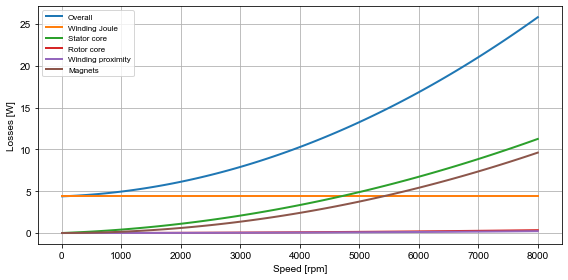

In [8]:
%matplotlib inline
from pyleecan.Classes.OutLoss import OutLoss
from SciDataTool.Functions.Plot.plot_2D import plot_2D

speed_array = np.linspace(10, 8000, 100)
p = machine.get_pole_pair_number()
outloss_list = list()
for speed in speed_array:
    out_dict = {"coeff_dict": out.loss.coeff_dict}
    outloss = OutLoss()
    outloss.store(out_dict, felec=speed / 60 * p)
    outloss_list.append(outloss)

joule_list = [o.Pjoule for o in outloss_list]
sc_list = [o.Pstator for o in outloss_list]
rc_list = [o.Protor for o in outloss_list]
prox_list = [o.Pprox for o in outloss_list]
mag_list = [o.Pmagnet for o in outloss_list]
ovl_list = [o.get_loss_overall() for o in outloss_list]

plot_2D(
    [speed_array],
    [ovl_list, joule_list, sc_list, rc_list, prox_list, mag_list],
    xlabel="Speed [rpm]",
    ylabel="Losses [W]",
    legend_list=[
        "Overall",
        "Winding Joule",
        "Stator core",
        "Rotor core",
        "Winding proximity",
        "Magnets",
    ]
)
